<img style="text-align:left;" src="https://github.com/Microsoft/sqlworkshops/blob/master/graphics/solutions-microsoft-logo-small.png?raw=true" alt="Microsoft">
<br>


# Use regression to predict wine quality, in-database Machine Learning with SQL Server

  *Note: see the sql-ml folder for sample code and instructions on how to set this up.
  This is for learning purposes only.*
    

I will use [wine quality data set](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)
from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.html).  
The dataset contains quality ratings (labels) for a 1599 red wine samples. 
The features are the wines' physical and chemical properties (11 predictors). 
We want to use these properties to predict the quality of the wine. 

  


Processing the data
-------------------

Let's start with collecting and preparing the data. I've created a database called `WineQuality` within my SQL Server instance on a Linux VM. So I'll import some packages, and then connect to SQL Server.  

Once we're connected, I can set the compute context to my SQL Server instance, so that no data is moved and all analysis is done within SQL Server.


In [23]:
from revoscalepy import RxInSqlServer, rx_get_compute_context, rx_set_compute_context, RxLocalSeq
import matplotlib.pyplot as plt
import pandas
import os
import sys

connection_string = 'Driver=ODBC Driver 17 for SQL Server;Server=Server;Database={WineQuality};UID=User;PWD=Password;'
localcc = RxLocalSeq()
sql_server_cc = RxInSqlServer(connection_string = connection_string)
sql_cc = rx_set_compute_context(sql_server_cc)
rx_set_compute_context(sql_cc)
rx_get_compute_context()

In [24]:
from revoscalepy import RxLocalSeq, RxInSqlServer, rx_get_compute_context, rx_set_compute_context
from revoscalepy import rx_exec, rx_data_step
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

## Data Exploration and Understanding

You always start by looking at the data. Not just the statistics, but also visually. This isn't a data science 101 course, so I won't get into it, but I highly recommend looking into data exploration and visualization if you aren't familiar. 

In these first few cells, we're just looking at what the columns are, and what some typical values are for red vs. white wine.

In [25]:
from revoscalepy import RxSqlServerData

query = """SELECT TOP(1000) * FROM [WineQuality].[dbo].[wine_data] WHERE color = 'red'"""
ds = RxSqlServerData(sql_query = query, connection_string = connection_string)
red = rx_data_step(input_data = ds)
red.head()

Rows Read: 1000, Total Rows Processed: 1000, Total Chunk Time: 0.022 seconds 


,facidity,vacidity,citric,sugar,chlorides,fsulfur,tsulfur,density,pH,sulphates,alcohol,quality,color
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6,red
4,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [26]:
query = """SELECT TOP(1000) *
  FROM [WineQuality].[dbo].[wine_data] WHERE color = 'white'"""
ds = RxSqlServerData(sql_query = query, connection_string = connection_string)
white = rx_data_step(input_data = ds)
white.head()

Rows Read: 1000, Total Rows Processed: 1000, Total Chunk Time: 0.026 seconds 


,facidity,vacidity,citric,sugar,chlorides,fsulfur,tsulfur,density,pH,sulphates,alcohol,quality,color
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,white
1,6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.9940000000000001,3.3,0.49,9.5,6,white
2,8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.057999999999999996,47.0,186.0,0.9956,3.19,0.4,9.9,6,white
4,7.2,0.23,0.32,8.5,0.057999999999999996,47.0,186.0,0.9956,3.19,0.4,9.9,6,white



The goal is to predict the quality of the wines. Let's see how this variable is distributed.

Rows Read: 1599, Total Rows Processed: 1599, Total Chunk Time: 0.005 seconds 
Rows Read: 4898, Total Rows Processed: 4898, Total Chunk Time: 0.008 seconds 
Histogram of Red and White Wine Qualities:


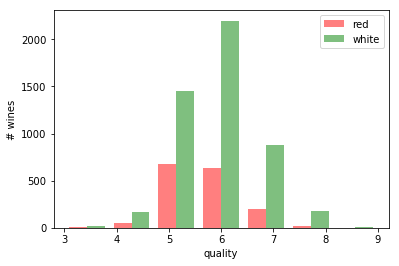

In [8]:
def compare_wines(red,white):
    red = rx_data_step(input_data = red)
    red = pd.to_numeric(red["quality"])
    white = rx_data_step(input_data = white)
    white = pd.to_numeric(white["quality"])
    fig, ax = plt.subplots(1, 1)
    ax.hist([red, white], label=["red", "white"], alpha=0.5,
            histtype='bar', bins=7, color=["red", "green"])
    ax.legend()
    ax.set_xlabel("quality")
    ax.set_ylabel("# wines")
    return

hist = rx_exec(function=compare_wines, 
               args={'red':ds_red, 'white':ds_white}, 
               compute_context = sql_cc)
print("Histogram of Red and White Wine Qualities:")


Predict the quality of the wine
-------------------------------

The quality is a mark between 1 and 9.
We use a fast tree regression to predict it.
But before anything starts, we need to split the dataset
into train and test.



In [11]:
query = """SELECT *
  FROM [WineQuality].[dbo].[wine_data]"""
ds = RxSqlServerData(sql_query = query, connection_string = connection_string)


def split_data(ds):
    try:
        from sklearn.model_selection import train_test_split
    except ImportError:
        from sklearn.cross_validation import train_test_split
    wines = rx_data_step(input_data=ds)
    wines_train, wines_test = train_test_split(wines, train_size=.75)
    return wines_train, wines_test

split_wines = rx_exec(function=split_data, 
               args={'ds':ds}, 
               compute_context = sql_cc)
train_data = split_wines[0][0]
test_data = split_wines[0][1]

Rows Read: 6497, Total Rows Processed: 6497, Total Chunk Time: 0.069 seconds 


And we train. We drop the color which is a non numerical
features. We will add it later.



In [12]:
from microsoftml import rx_logistic_regression, rx_fast_trees
cols = train_data.columns.drop(["quality", "color"])
ds = train_data.drop('color',axis=1).apply(pd.to_numeric)
model = rx_fast_trees("quality ~" + "+".join(cols), data=ds, method="regression", compute_context = sql_cc)


'unbalanced_sets' ignored for method 'regression'
Not adding a normalizer.
Making per-feature arrays
Changing data from row-wise to column-wise
Beginning processing data.
Rows Read: 4872, Read Time: 0, Transform Time: 0
Beginning processing data.
Processed 4872 instances
Binning and forming Feature objects
Reserved memory for tree learner: 277992 bytes
Starting to train ...
Not training a calibrator because it is not needed.
Elapsed time: 00:00:01.6747879
Elapsed time: 00:00:00.2648222


Next, let's make some predictions with our tests data to see how our model does.



In [13]:
from microsoftml import rx_predict
ds = test_data.drop('color',axis=1).apply(pd.to_numeric)
pred = round(rx_predict(model = model, data = ds, extra_vars_to_write=["quality"]),1)
print(pred.head())

Beginning processing data.
Rows Read: 1625, Read Time: 0, Transform Time: 0
Beginning processing data.
Elapsed time: 00:00:00.3216846
Finished writing 1625 rows.
Writing completed.
   quality  Score
0      5.0    5.2
1      5.0    5.3
2      4.0    5.4
3      5.0    4.6
4      6.0    6.1


R2= 0.424355761041


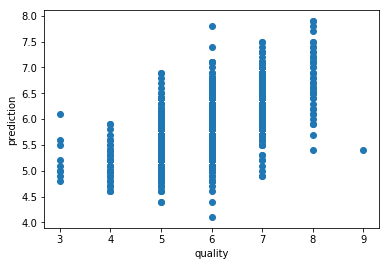

In [14]:
from sklearn.metrics import r2_score
r2 = r2_score(pred.quality, pred.Score)
print("R2=", r2)

fig, ax = plt.subplots(1, 1)
ax.scatter(x=pred.quality, y=pred.Score)
ax.set_xlabel("quality")
ax.set_ylabel("prediction")

Can we find a better model?
--------------------

As is standard for creating and deploying machine learning models, it's important to try several algorithms before you deploy one, to make sure you're using a model that produces the most accurate results. Here are some other built-in packages that we could try:

- rx_btrees
- rx_fast_trees
- rx_dforest


For the purpose of this exercise, we'll just assume this is the best model after our experimentation.

## Creating the Stored Procedure for Model Deployment

Once we have a model we're satisfied with, we may want to deploy it into production in SQL Server. In order to do this, we'll need to create a Stored Procedure. 

Fortunately for all the non-SQL developers, there is an open-source package available `sqlmlutils` that can help transform your Python code into a format accepted by SQL Server, specifically a Stored Procedure in this use case.

You can follow the instructions to install and use `sqlmlutils` in your own projects [here](https://github.com/Microsoft/sqlmlutils/tree/master/Python).

In [17]:
import sqlmlutils
import pytest

def train_model_sproc():
    import numpy
    import pickle
    from sklearn.linear_model import LogisticRegression
    from revoscalepy import RxLocalSeq, RxInSqlServer, rx_get_compute_context, rx_set_compute_context
    from revoscalepy import rx_exec, rx_data_step
    from microsoftml import rx_logistic_regression, rx_fast_trees
    import pandas as pd

    cols = InputDataSet.columns.drop(["quality", "color"])
    ds = InputDataSet.drop("color",axis=1).apply(pd.to_numeric)
    mod = rx_fast_trees("quality ~" + "+".join(cols), data=ds, method="regression")
    
    # This is the same code (above), just put into function-form with the needed packages
    # Below, we've added a dump of the model so we can refer to it later in SQL Server
    trained_model = pickle.dumps(mod)
    

connection = sqlmlutils.ConnectionInfo(server="Server", database="WineQuality",uid="User",pwd="Password")
sqlpy = sqlmlutils.SQLPythonExecutor(connection)
sp_name = "TrainModel"

sqlpy.drop_sproc(sp_name)
sqlpy.create_sproc_from_function(sp_name, train_model_sproc)


True